In [87]:
library('tidyverse')
library('data.table')
library('parallel')
library('dplyr')
library('ggpubr')

In [88]:
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  
  if(luminance < 128){
  
  return('white')
      
  }else{return('black')}
}
color_annotation<-read.csv('/home//workspace/IHA_Figure_Revision/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [89]:
meta_data<- read.csv('/home//workspace/IHA_Figure_Revision/Dataset/scRNA_meta_data-2024-05-09.csv')

In [90]:
IHM<-read.csv('01_IHM_Metric/IHM_Score.csv')%>% select(sample.sampleKitGuid,surrogate.score)
colnames(IHM)[2]<-"IHM_Score"
IHM<-IHM[!duplicated(IHM$sample.sampleKitGuid),]
IHM<-left_join(IHM, meta_data) %>% filter(sample.visitName=="Flu Year 1 Day 0") %>% filter(subject.subjectGuid!="BR1013")

Joining with `by = join_by(sample.sampleKitGuid)`


In [91]:
composite_score_up<-read.csv('/home//workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Figure1/04_CompositeScore/BRI_CompositeScore_Up.csv')%>% select(sample.sampleKitGuid,composite_score_sum_scaled_mean,celltype	)

In [92]:
df<-left_join(IHM,composite_score_up)

Joining with `by = join_by(sample.sampleKitGuid)`


In [93]:
celltype_order<-c("Core naive CD8 T cell","CM CD8 T cell","GZMK+ CD27+ EM CD8 T cell","Naive CD4 Treg",
                 "Core naive CD4 T cell","CM CD4 T cell","GZMB- CD27- EM CD4 T cell","GZMB- CD27+ EM CD4 T cell")
df$celltype<-factor(df$celltype,levels=celltype_order)
celltype_order_wrapped <- str_wrap(celltype_order, width = 12)


In [94]:
df$celltype <- gsub(" cell", '', df$celltype)
names(color_vector)<-str_wrap(names(color_vector), width = 12)
df$celltype_wrapped <- str_wrap(df$celltype, width = 12)
strip_colors <- setNames(
  color_vector[ unique(df$celltype_wrapped) ],
  unique(df$celltype_wrapped)
)

In [95]:
#df$celltype_wrapped<-factor(df$celltype_wrapped,levels=celltype_order_wrapped)


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


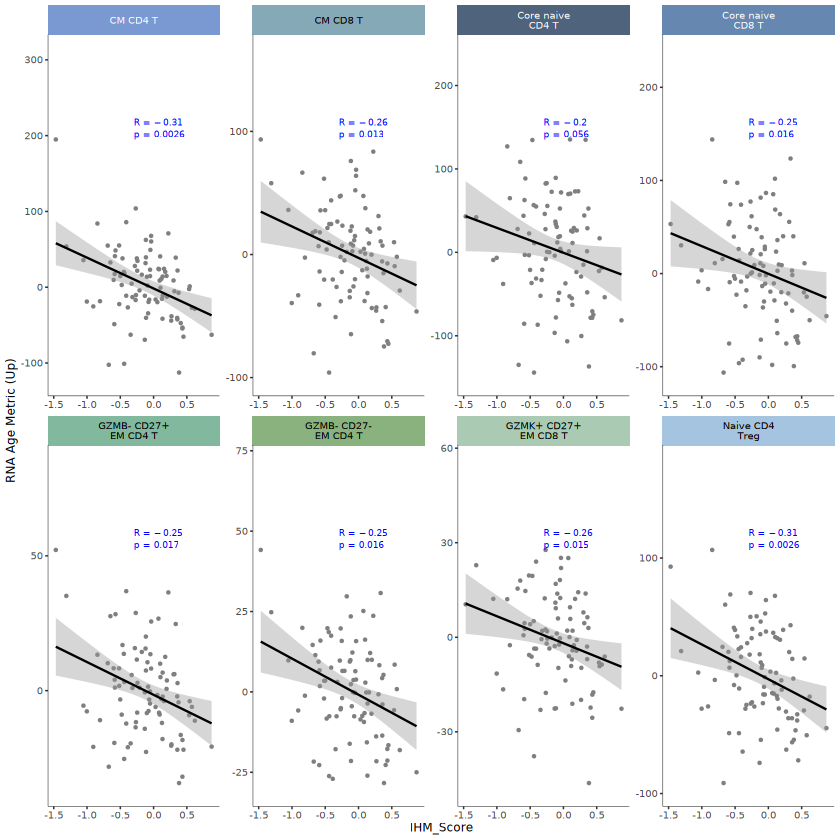

In [99]:
p <- ggplot(data = df, aes(x = IHM_Score, y = composite_score_sum_scaled_mean)) + 
  geom_point(size = 1, stroke = 0, aes(color = cohort.cohortGuid)) +
  geom_smooth(method = lm, color = "black", linewidth = 0.5, se = TRUE) +
  scale_color_manual(values = c("Older" = "#bf812d", "Young" = "#35978f")) +
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.45))) +
  facet_wrap(~celltype_wrapped, scales = "free", ncol = 4) +
  stat_cor(aes(label = ..r.label..), method = "spearman",
           label.x.npc = 0.5, label.y.npc = "top", vjust = -2, size = 1.76, color = "blue") +
  stat_cor(aes(label = ..p.label..), method = "spearman",
           label.x.npc = 0.5, label.y.npc = "top", vjust = 0, size = 1.76, color = "blue") +
  ylab("RNA Age Metric (Up)") +
  coord_cartesian(clip = "off") +
  theme_classic(base_size = 7) +
  theme(
    axis.line = element_line(colour = "black", linewidth = 0.1),
    legend.position = "top",
    panel.grid = element_blank(),
    strip.background = element_rect(linewidth = 0),
    axis.title.x = element_text(margin = margin(t = 1))
  )

plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl("strip-", plot$layout$name))
pal <- color_vector[celltype_order_wrapped]
text_color <- sapply(color_vector[celltype_order_wrapped], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl("rect", plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl("titleGrob", plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjustcolor(pal[i], alpha.f = 0.8)
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureB.pdf',plot,width = 120/25.4, height =  60/25.4)